# Build a Simple Regression Model to Predict the Price

## Load some some Stuff

Start by resusing some code from task1.ipynb

In [14]:
## Import the already downloaded dataset

import pandas as pd
import numpy as np

df = pd.read_csv('dataset/vehicles.csv', delimiter=',')

In [15]:
# checking each column for missing values, unique values, most frequent value, string lengths, etc

def summarize_columns(df):
    n = len(df)
    rows = []
    for col in df.columns:
        ser = df[col]
        dtype = ser.dtype
        non_null = ser.count()
        missing = n - non_null
        missing_pct = missing / n if n > 0 else np.nan
        unique = ser.nunique(dropna=True)
        is_cat = isinstance(ser.dtype, pd.CategoricalDtype)
                
        row = {
            "dtype": str(dtype),
            "non_null": non_null,
            "missing": missing,
            "missing_pct": round(missing_pct, 4),
            "unique": unique,
            "is_categorical": is_cat                       
        }

        mode = ser.mode(dropna=True)
        top = mode.iloc[0] if not mode.empty else np.nan
        vc = ser.value_counts(dropna=True)
        top_freq = int(vc.iloc[0]) if not vc.empty else 0
        str_ser = ser.dropna().astype(str)
        
        if not str_ser.empty:
            lens = str_ser.map(len)
            row.update({
                "top": top,
                "top_freq": top_freq,
                "avg_len": lens.mean(),
                "min_len": lens.min(),
                "max_len": lens.max()
            })
        else:
            row.update({
                "top": top,
                "top_freq": top_freq,
                "avg_len": np.nan,
                "min_len": np.nan,
                "max_len": np.nan
            })

        rows.append({"column": col, **row})

    summary = pd.DataFrame(rows).set_index("column").sort_index()
    return summary


## Tidy up Dataset

In [16]:
## building my version of the data set by removing some columns
df2 = df.copy()

## to make data set considerably smaller for faster processing - drop description column if present
df2 = df2.drop(columns=['description'], errors='ignore')

## drop some columns that are not useful for analysis (ignore if missing)
df2 = df2.drop(columns=['id', 'image_url', 'region_url', 'url'], errors='ignore')
## county - often missing
## image_url - URL no longer exists
## region_url - not relevant
## url - URL no longer exists

## clean up geographical information which shows up in various granularity. at the moment, evrything geographic is removed.
df2 = df2.drop(columns=['lat', 'long', 'county', 'region'], errors='ignore')

## drop vehicles which show up multiple times (ignore if missing), NOTE: we drop a vehicle completely if there is a duplicate
df2 = df2.drop_duplicates(subset=['VIN'], ignore_index=True)
df2 = df2.drop(columns=['VIN'], errors='ignore')

## throw away some categorical variables which have many unique values (ignore if missing)
df2 = df2.drop(columns=['model', 'posting_date'], errors='ignore')
               
summary = summarize_columns(df2)
display(summary)

## drop entries with car price smaller than 100
df2 = df2[df2['price'] >= 100]


,dtype,non_null,missing,missing_pct,unique,is_categorical,top,top_freq,avg_len,min_len,max_len
column,,,,,,,,,,,
condition,object,61100,57165,0.4834,6,False,excellent,32074,6.881882,3,9
cylinders,object,70281,47984,0.4057,8,False,4 cylinders,26128,10.964941,5,12
drive,object,90912,27353,0.2313,3,False,4wd,40261,3.000000,3,3
fuel,object,116626,1639,0.0139,5,False,gas,100652,3.352280,3,8
manufacturer,object,115192,3073,0.0260,41,False,ford,18792,5.780462,3,15
odometer,float64,116689,1576,0.0133,79972,False,0.0,615,7.298623,3,10
paint_color,object,87578,30687,0.2595,12,False,white,22799,4.810523,3,6
price,int64,118265,0,0.0000,12023,False,0,12678,4.236655,1,9
size,object,30321,87944,0.7436,4,False,full-size,15705,8.444543,7,11


In [17]:
from pandas.api import types as ptypes

def convert_text_to_category(df, max_unique=100):
    """
    Convert object/string columns with <= max_unique distinct values to 'category' dtype.
    Returns list of (column, n_unique) converted.
    """
    converted = []
    for col in df.columns:
        ser = df[col]

        # candidate: object or string dtype (text-like)
        if ptypes.is_object_dtype(ser) or ptypes.is_string_dtype(ser):
            nuniq = int(ser.nunique(dropna=True))
            if nuniq <= max_unique:
                df[col] = ser.astype('category')
            else:
                print(f"Skipping column '{col}' with {nuniq} unique values (exceeds max_unique={max_unique})")
    return df

# run on df2 (or df) with a cardinality threshold you choose
df2 = convert_text_to_category(df2, max_unique=100)



display(summarize_columns(df2))



,dtype,non_null,missing,missing_pct,unique,is_categorical,top,top_freq,avg_len,min_len,max_len
column,,,,,,,,,,,
condition,category,56604,48598,0.4619,6,True,excellent,29187,6.842891,3,9
cylinders,category,64499,40703,0.3869,8,True,4 cylinders,24117,10.972852,5,12
drive,category,81716,23486,0.2232,3,True,4wd,36168,3.000000,3,3
fuel,category,103839,1363,0.0130,5,True,gas,90187,3.341904,3,8
manufacturer,category,102309,2893,0.0275,41,True,ford,16613,5.790781,3,15
odometer,float64,104507,695,0.0066,73318,False,0.0,483,7.321844,3,10
paint_color,category,79509,25693,0.2442,12,True,white,20477,4.810336,3,6
price,int64,105202,0,0.0000,11961,False,9995,1207,4.636490,3,9
size,category,27117,78085,0.7422,4,True,full-size,14003,8.446657,7,11


## Perform Regression

In [18]:
# (pandas is already imported earlier in the notebook)
import statsmodels.formula.api as smf

## TODO: if there is a missing value, the whole data row is ignored by statsmodels. Need to handle missing values properly.

# use the prepared dataframe available in the notebook
df_model = df2.copy()
# drop unwanted columns from the dataframe (use DataFrame.drop, not Index.drop)
df_model = df_model.drop(columns=['state', 'manufacturer'], errors='ignore')

# identify predictors (all columns except price)
predictors = df_model.columns.drop('price')

# split numeric vs categorical
numeric_cols = [c for c in predictors if pd.api.types.is_numeric_dtype(df_model[c])]
cat_cols = [c for c in predictors if c not in numeric_cols]


# build patsy formula: numeric columns as-is, categorical wrapped as C(col)
terms = numeric_cols + [f"C({c})" for c in cat_cols]
formula = "price ~ " + " + ".join(terms)

# fit OLS and print summary (similar to R's summary(lm(...)))
model = smf.ols(formula, data=df_model).fit()

# add R-style significance stars
def p_stars(p):
    if pd.isna(p):
        return ""
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    if p < 0.1:
        return "."
    return ""

coefs = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "pval": model.pvalues,
    "conf_low": model.conf_int().iloc[:, 0],
    "conf_high": model.conf_int().iloc[:, 1],
})

coefs["sig"] = coefs["pval"].apply(p_stars)


# show augmented coefficient table then the full statsmodels summary
out = coefs[["sig", "coef", "std_err", "t", "pval", "conf_low", "conf_high"]]
print(model.summary())
display(out)



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     298.6
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:24:50   Log-Likelihood:            -2.2414e+05
No. Observations:               21175   AIC:                         4.484e+05
Df Residuals:                   21121   BIC:                         4.488e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

,sig,coef,std_err,t,pval,conf_low,conf_high
Intercept,***,-784935.739012,18816.394709,-41.715523,0.000000e+00,-821817.308502,-748054.169521
C(condition)[T.fair],***,-6145.412303,460.420869,-13.347380,1.790046e-40,-7047.872341,-5242.952264
C(condition)[T.good],***,-3082.125025,153.215737,-20.116243,3.640112e-89,-3382.439562,-2781.810488
C(condition)[T.like new],***,3426.829401,213.199240,16.073366,8.639381e-58,3008.942621,3844.716181
C(condition)[T.new],***,14043.234194,901.457792,15.578360,2.051811e-54,12276.308133,15810.160255
C(condition)[T.salvage],**,-4965.333774,1621.432642,-3.062313,2.199100e-03,-8143.465482,-1787.202066
C(cylinders)[T.12 cylinders],***,16616.608996,2566.369720,6.474753,9.705623e-11,11586.328508,21646.889485
C(cylinders)[T.3 cylinders],***,-7501.221027,1690.372870,-4.437613,9.142192e-06,-10814.480842,-4187.961212
C(cylinders)[T.4 cylinders],***,-6101.916551,928.333674,-6.572978,5.047014e-11,-7921.521393,-4282.311710
C(cylinders)[T.5 cylinders],***,-6383.619259,1121.843614,-5.690293,1.285005e-08,-8582.518350,-4184.720168


## Diagnostic Plots

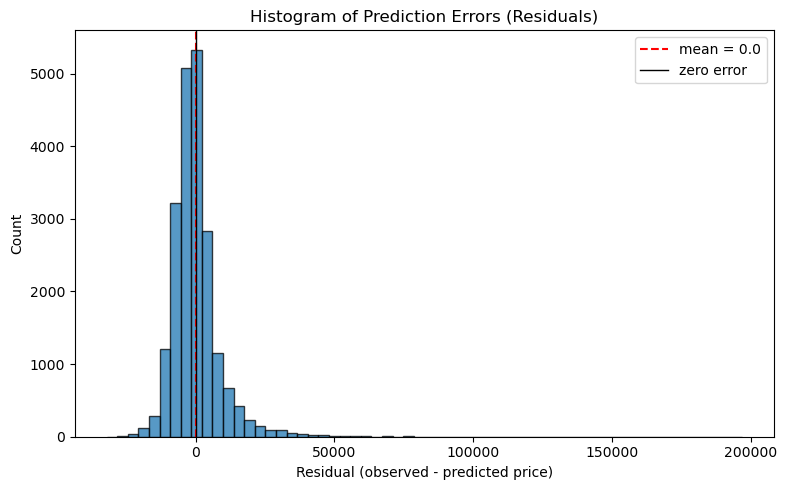

n = 21175, mean = 0.00, std = 9569.42, min = -32089.15, max = 196884.40


In [19]:
import matplotlib.pyplot as plt

# residuals from the fitted model (observed - predicted for observations used in the fit)
resid = model.resid.values if hasattr(model.resid, "values") else np.asarray(model.resid)

# plot histogram
plt.figure(figsize=(8,5))
plt.hist(resid, bins=60, color="C0", edgecolor="k", alpha=0.75)
mu = resid.mean()
sigma = resid.std(ddof=0)
plt.axvline(mu, color="r", linestyle="--", linewidth=1.5, label=f"mean = {mu:.1f}")
plt.axvline(0, color="k", linestyle="-", linewidth=1, label="zero error")
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Residual (observed - predicted price)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# optional quick stats
print(f"n = {resid.size}, mean = {mu:.2f}, std = {sigma:.2f}, min = {resid.min():.2f}, max = {resid.max():.2f}")

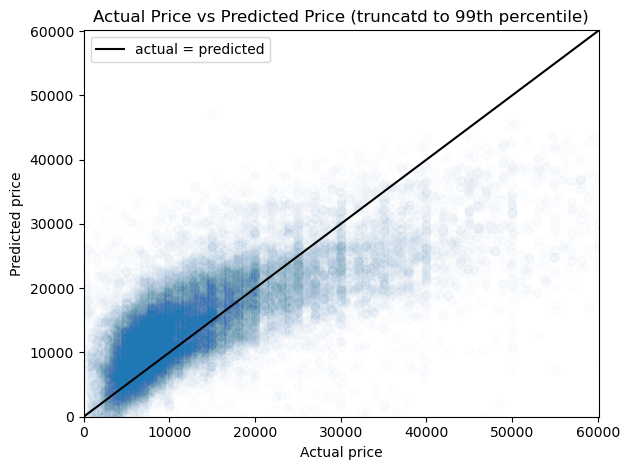

In [38]:
# Actual vs Predicted (swap axes: x=Actual, y=Predicted)
# Use the observations that were actually used in the fit.
y_pred_fit = model.fittedvalues
y_true_fit = model.model.endog


plt.scatter(y_true_fit, y_pred_fit, alpha=0.01)
upper = float(np.nanpercentile(y_true_fit, 99))
lims = [0, upper]
plt.plot(lims, lims, color='k', linewidth=1.5, label='actual = predicted')
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual Price vs Predicted Price (truncatd to 99th percentile)')
plt.tight_layout()
plt.show()
